In [5]:
import os
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from warnings import simplefilter
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
from nltk.stem import WordNetLemmatizer 
import random


simplefilter(action='ignore', category=FutureWarning)

train_positive_path = '../Sentiment_Analysis/aclImdb/train/pos/'
train_negative_path = '../Sentiment_Analysis/aclImdb/train/neg/'
test_positive_path = '../Sentiment_Analysis/aclImdb/test/pos/'
test_negative_path = '../Sentiment_Analysis/aclImdb/test/neg/'

def read_files_in_path(path):
    positive_training_data=[]
    for filepath in glob.glob(os.path.join(path, '*.txt')):
        with open(filepath,encoding='utf8') as f:
            content = f.read()
            positive_training_data.append(content)
    return positive_training_data

#Read training data
positive_training_data = read_files_in_path(train_positive_path)
negative_training_data = read_files_in_path(train_negative_path)
whole_training_data = positive_training_data+negative_training_data

#Reading Test Data
positive_test_data = read_files_in_path(test_positive_path)
negative_test_data = read_files_in_path(test_negative_path)
whole_test_data = positive_test_data+negative_test_data


In [6]:
#Remove HTML tags from dataset
def cleanhtml(whole_training_data):
    no_HTML_whole_training_data = []
    cleaner = re.compile('<.*?>')
    for review in whole_training_data:
        cleantext = re.sub(cleaner, '', review)
        no_HTML_whole_training_data.append(cleantext)
    return no_HTML_whole_training_data

#Remove stop words, punctuation and Lemmatize words
def remove_punc_stop_words(no_HTML_whole_training_data):
    clean_training_data = []
    for review in no_HTML_whole_training_data:
        #remove punctuation marks
        review = review.lower()
        for ch in string.punctuation:
            review = review.replace(ch,' ')
        #Remove stop words
        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(review) 
        filtered_words = [w for w in word_tokens if not w in stop_words] 
        #construct the review again
        sentence =''
        for word in filtered_words:
            sentence+=lemmatize_word(word)
            sentence+=' '
        clean_training_data.append(sentence)
    return clean_training_data


def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)


#clean data from HTML tags
no_HTML_whole_training_data = cleanhtml(whole_training_data)
# print(whole_training_data[210])
# print('\n',no_HTML_whole_training_data[210])

clean_training_data = remove_punc_stop_words(no_HTML_whole_training_data)
# print(set(stopwords.words('english')))
# print('\n',no_HTML_whole_training_data[210])
# print('\n',clean_training_data[210])
# print('\n',no_HTML_whole_training_data[310])
# print('\n',clean_training_data[310])
# print('\n',no_HTML_whole_training_data[4510])
# print('\n',clean_training_data[4510])
no_HTML_whole_test_data = cleanhtml(whole_test_data)
clean_test_data = remove_punc_stop_words(no_HTML_whole_test_data)

           Frequency
Word                
movie          51684
film           47028
one            27736
like           20736
time           15955
good           15197
character      14172
story          13165
even           12642
get            12514
would          12436
make           12224
see            12012
really         11736
well           10778
scene          10584
much            9763
people          9384
bad             9301
also            9156


Text(0, 0.5, 'Count')

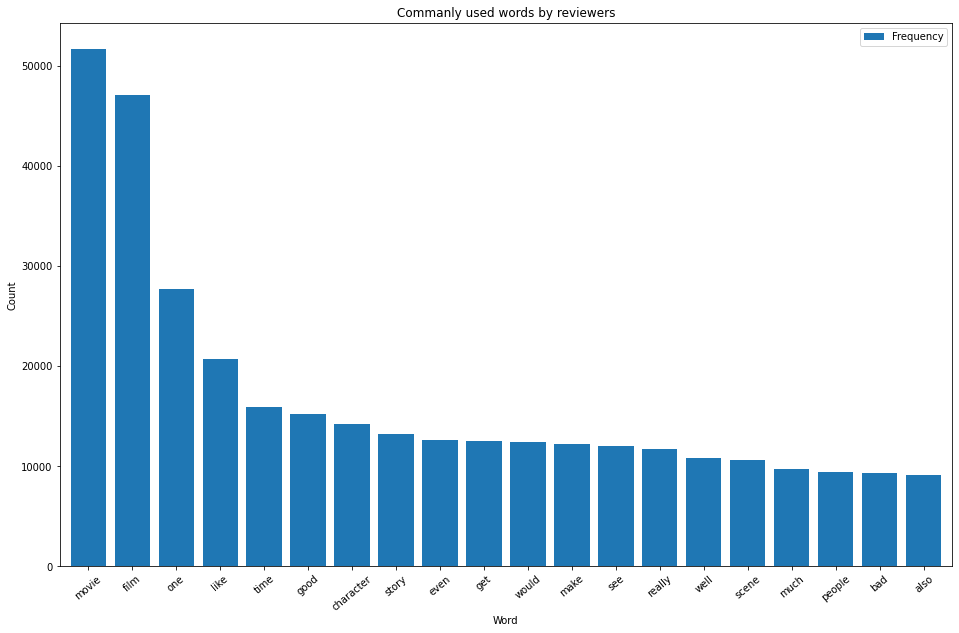

In [7]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# my_words = list()
# for review in clean_training_data:
#     my_words.append(review)
df = pd.DataFrame(my_words,columns=['text'])  

my_stopwords = stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(my_stopwords))
words = (df.text
           .str.lower()
           .replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\'', RE_stopwords], [' ', '','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)
# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(20),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

rslt_wordcloud = pd.DataFrame(Counter(words).most_common(100),
                    columns=['Word', 'Frequency'])
#BAR CHART
rslt.plot.bar(rot=40, figsize=(16,10), width=0.8,colormap='tab10')
plt.title("Commanly used words by reviewers")
plt.ylabel("Count")


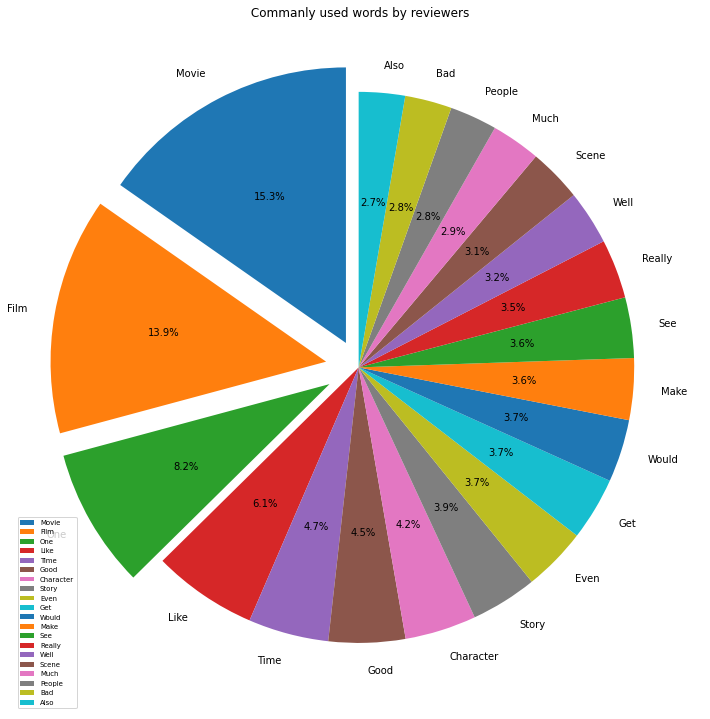

In [8]:

from pylab import rcParams
rcParams['figure.figsize'] = 10,15

#PIE CHART

explode = (0.1, 0.12, 0.122, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)  # explode 1st slice
labels=['Movie','Film','One','Like','Time','Good','Character','Story','Even','Get','Would','Make','See','Really','Well','Scene',
       'Much','People','Bad','Also']

plt.pie(rslt['Frequency'], explode=explode,labels =labels , autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.legend( labels, loc='lower left',fontsize='x-small',markerfirst = True)
plt.tight_layout()
plt.title(' Commanly used words by reviewers')
plt.show()

import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0

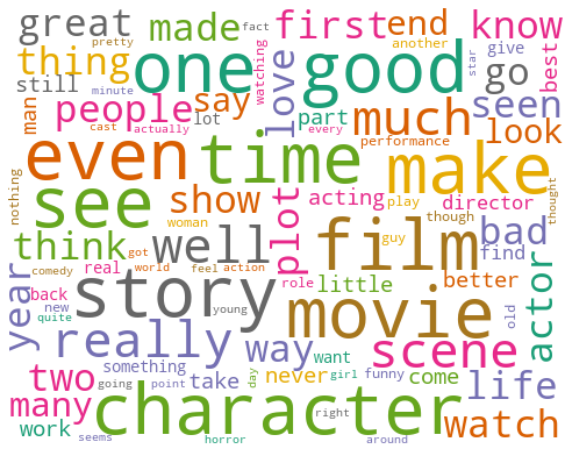

<Figure size 720x720 with 0 Axes>

In [11]:

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

wordcloud = WordCloud(max_font_size=60, max_words=300, width=480, height=380,colormap="Dark2_r",
                      background_color="white").generate(' '.join(rslt_wordcloud['Word']))
                      
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=[10,10])
plt.show()

In [12]:
#create labels for the training data and test data first 12500 are positive and the remaining 12500 are negative
train_labels = np.asarray([1]*len(positive_training_data) + [0]*len(negative_training_data))
test_labels = np.asarray([1]*len(positive_test_data) + [0]*len(negative_test_data))

#randomize test data
z = list(zip(clean_training_data, train_labels))
random.shuffle(z)
random_clean_training_data, random_train_labels = zip(*z)

#Apply feature extraction: countVectorizer which is based on bag of words algorithm
vectorizer = CountVectorizer(ngram_range=(1,2))
train_vector = vectorizer.fit_transform(random_clean_training_data)
test_vector = vectorizer.transform(clean_test_data)
#printing some visualization of the sizes of the train and test vectors 
#print(train_labels.shape)
#train_vector has 25000 row corresponding to the 25000 review and 74849 feature extracted
#print(train_vector.shape)

#print shapes of test vector and label

# print(test_labels.shape)
# print(test_vector.shape)

#some visualization for th labels arrays
# print(random_train_labels)
# print(test_labels)
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(train_vector, random_train_labels)
print("Decision tree classification accuracy:\n",clf.score(test_vector,test_labels)*100,"%")


Decision tree classification accuracy:
 73.004 %
